In [16]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1)
        out._backward = _backward

        return out
        
    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [5]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label='d'
e = d+c; e.label='e'
f = Value(-2.0, label='f')
L = e*f; L.label='L'

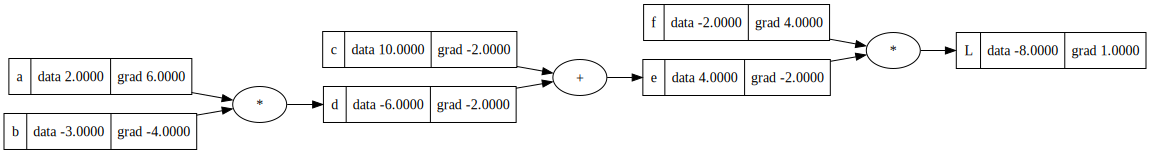

In [11]:
draw_dot(L)

In [7]:
L.backward()

In [10]:
for i in []:
    print(i)

In [12]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []
        

class Neuron(Module):

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
            act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
            out = act.tanh()
            return out

    def parameters(self):
        return self.w + [self.b]

class Layer(Module):

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [13]:
model = MLP(3, [4,4,1])

In [14]:
model.parameters()

[Value(data=-0.4605288700916821),
 Value(data=-0.48002275285571705),
 Value(data=-0.34441603994052095),
 Value(data=-0.6070460102613824),
 Value(data=0.6329868769072715),
 Value(data=-0.9881911003289312),
 Value(data=0.7257381533525191),
 Value(data=0.2968983997289054),
 Value(data=-0.8104589497257229),
 Value(data=-0.4547713647012557),
 Value(data=0.5106048513517731),
 Value(data=-0.08772423381449301),
 Value(data=0.33605263923313866),
 Value(data=0.10760751222106868),
 Value(data=-0.4245306365220507),
 Value(data=-0.7183401605340602),
 Value(data=-0.8437138491242988),
 Value(data=-0.727379987120256),
 Value(data=-0.5808567136682563),
 Value(data=0.11635103794314694),
 Value(data=-0.8729859446658552),
 Value(data=0.17527193374401362),
 Value(data=0.4940431740847844),
 Value(data=0.42951671579102535),
 Value(data=0.5461077767745461),
 Value(data=-0.6239003785443769),
 Value(data=0.5518257516791649),
 Value(data=0.7777719688862543),
 Value(data=-0.6065422769975997),
 Value(data=0.639164

In [17]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [model(x) for x in xs]
ypred

[Value(data=0.9531091727578778),
 Value(data=0.9817482490578803),
 Value(data=0.9737889067341212),
 Value(data=0.9794154602573879)]

In [19]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.825791243946517)

In [ ]:
for p in model.parameters():
    p.data += -0.01 * p.grad

In [210]:
## rodar treinamento

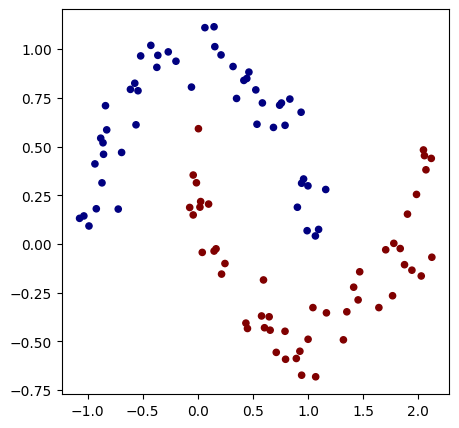

In [21]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [ ]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

y = [1.0, -1.0, -1.0, 1.0]

In [29]:
num_epochs = 100
learning_rate = 0.01
model = MLP(2, [10, 10, 1])

for k in range(num_epochs):
    model.zero_grad()
    y_hat = [model(x) for x in X]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(y, y_hat)])
    loss.backward()

    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k%5 == 0:
        print(f' epoch: {k} | loss : {loss.data}')
    

 epoch: 0 | loss : 133.92040789231066
 epoch: 5 | loss : 89.34648666866998
 epoch: 10 | loss : 71.08248497804645
 epoch: 15 | loss : 71.0991141405041
 epoch: 20 | loss : 37.08514206657099
 epoch: 25 | loss : 77.82339445880253
 epoch: 30 | loss : 37.43267471010154
 epoch: 35 | loss : 36.49291471536804
 epoch: 40 | loss : 35.90287603083879
 epoch: 45 | loss : 35.38676791283696
 epoch: 50 | loss : 34.8169750583234
 epoch: 55 | loss : 34.2453742272038
 epoch: 60 | loss : 31.245183728740724
 epoch: 65 | loss : 22.297011509072266
 epoch: 70 | loss : 13.116556510213627
 epoch: 75 | loss : 4.63915367079889
 epoch: 80 | loss : 2.7296820774635426
 epoch: 85 | loss : 1.232369235438578
 epoch: 90 | loss : 0.8904494660536374
 epoch: 95 | loss : 0.768429470968916


In [22]:
model = MLP(2, [5, 5, 1])

In [25]:
len([model(x) for x in X])

100